In [3]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from skimage.io import imread, imsave

# adjust contrast
from skimage import exposure
# reduce noise with morphological filter
from skimage.morphology import opening, closing, disk
# thresholding
from skimage.filters import threshold_otsu, try_all_threshold, threshold_local, threshold_triangle
# segmentation
from scipy.ndimage import label

In [4]:
import os

# load_dir = "/home/cullen/nfs/gorbsky_data/input_data/"
load_dir = "/gorbsky_data/input_data/"
files = [f for f in os.listdir(load_dir) if f.endswith(".tif")]

In [4]:
imgs = imread(load_dir+files[0])
print(imgs.shape)

(289, 1608, 1608)


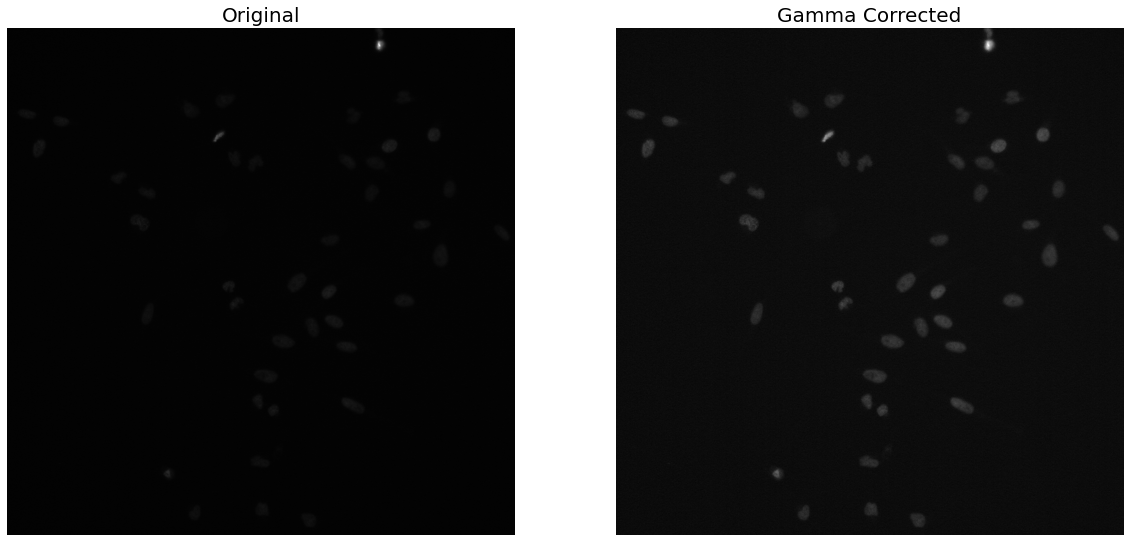

In [5]:
img = imgs[0]

plt.figure(figsize=(20, 15))

plt.subplot(121)
plt.imshow(img, cmap="gray")
plt.axis('off')
plt.title("Original",fontsize=20,)

plt.subplot(122)
plt.imshow(exposure.adjust_gamma(img, 0.1), cmap="gray")
plt.axis('off')
plt.title("Gamma Corrected",fontsize=20)

plt.show()

In [6]:
img = imgs[0]
selem = disk(6)
img_dn = closing(opening(img, selem), selem)

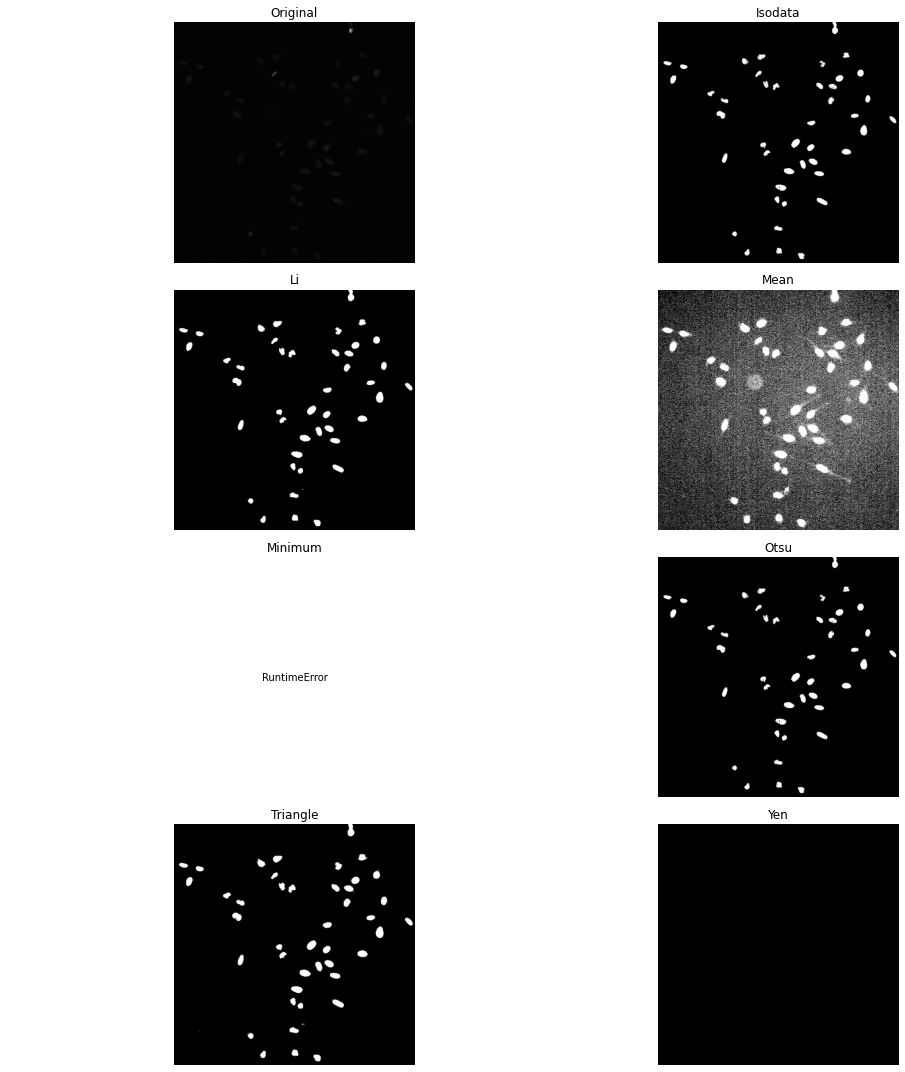

In [7]:
try_all_threshold(img, figsize=(15, 15), verbose=False)
plt.show()

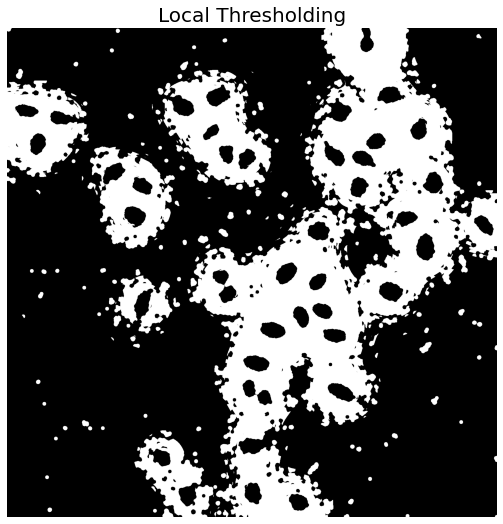

In [8]:
plt.figure(figsize=(9, 9))

thresh_local = threshold_local(img_dn, 333, offset=5)
local = (img_dn > thresh_local) +0
plt.imshow(local, cmap="Greys")
plt.axis('off')
plt.title("Local Thresholding",fontsize=20)
plt.show()

In [7]:
# grid_search = {
#     'block_size': [3, 15, 155, 303],
#     'method': ['generic', 'gaussian', 'mean', 'median'],
#     'offset': [0, 3, 6, 9],
#     'mode': ['reflect', 'constant', 'nearest', 'mirror', 'wrap']
# }

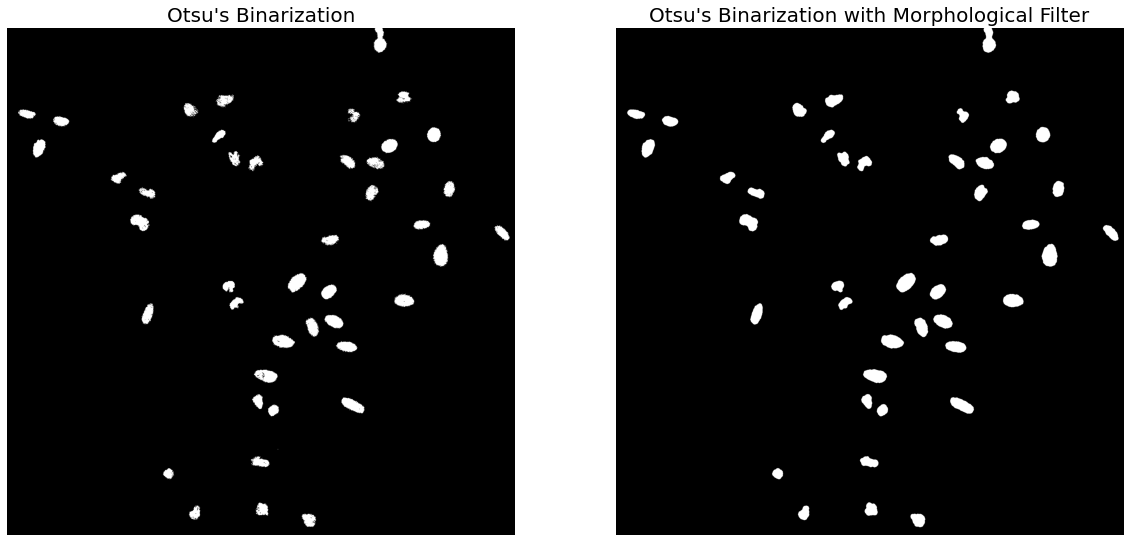

In [8]:


plt.figure(figsize=(20, 15))

plt.subplot(121)
thresh_otsu = threshold_otsu(img) 
otsu = (img > thresh_otsu) +0
plt.imshow(otsu, cmap="gray")
plt.axis('off')
plt.title("Otsu's Binarization",fontsize=20,)

plt.subplot(122)
thresh_otsu_dn = threshold_otsu(img_dn)
otsu_dn = (img_dn > thresh_otsu_dn) +0
plt.imshow(otsu_dn, cmap="gray")
plt.axis('off')
plt.title("Otsu's Binarization with Morphological Filter",fontsize=20)

plt.show()

In [9]:
from scipy.ndimage import label

labeled_cells, num_cells = label(otsu_dn)

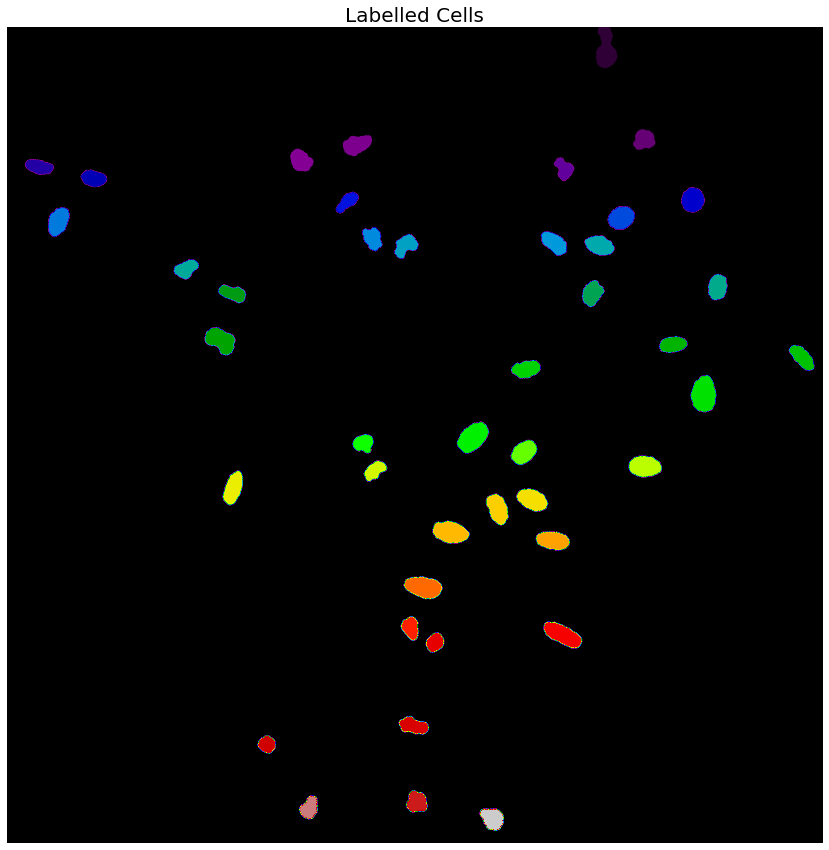

In [10]:
plt.figure(figsize=(15, 15))

plt.imshow(labeled_cells,'nipy_spectral')
plt.axis('off')
plt.title('Labelled Cells', fontsize=20)
plt.show()

In [11]:
def get_contour(binary_image, four_connected=True):
    shape = binary_image.shape
    contour = np.zeros(shape,dtype=bool)
    zero_padded = np.zeros((shape[0]+2,shape[1]+2))
    zero_padded[1:shape[0]+1,1:shape[1]+1] = binary_image
    for i in range(1,shape[0]+1):
        for j in range(1,shape[1]+1):
            if zero_padded[i,j]==1:
                up_down = zero_padded[i,j-1]==0 or zero_padded[i,j+1]==0
                left_right = zero_padded[i-1,j]==0 or zero_padded[i+1,j]==0
                if up_down or left_right:
                    contour[i-1,j-1] = True
                else:
                    if not four_connected:
                        left_corners = zero_padded[i-1,j-1]==0 or zero_padded[i-1,j+1]==0
                        right_corners = zero_padded[i+1,j-1]==0 or zero_padded[i+1,j+1]==0
                        if left_corners or right_corners:
                            contour[i-1,j-1] = True
    return (contour, int(np.sum(contour)))

In [12]:
from tqdm import tqdm

contours = []
contour_lengths = []
for i in tqdm(range(num_cells)):
    cur_cont, cur_len = get_contour(labeled_cells==(i+1),four_connected=False)
    contours.append(cur_cont)
    contour_lengths.append(cur_len)

100%|██████████| 43/43 [00:39<00:00,  1.08it/s]


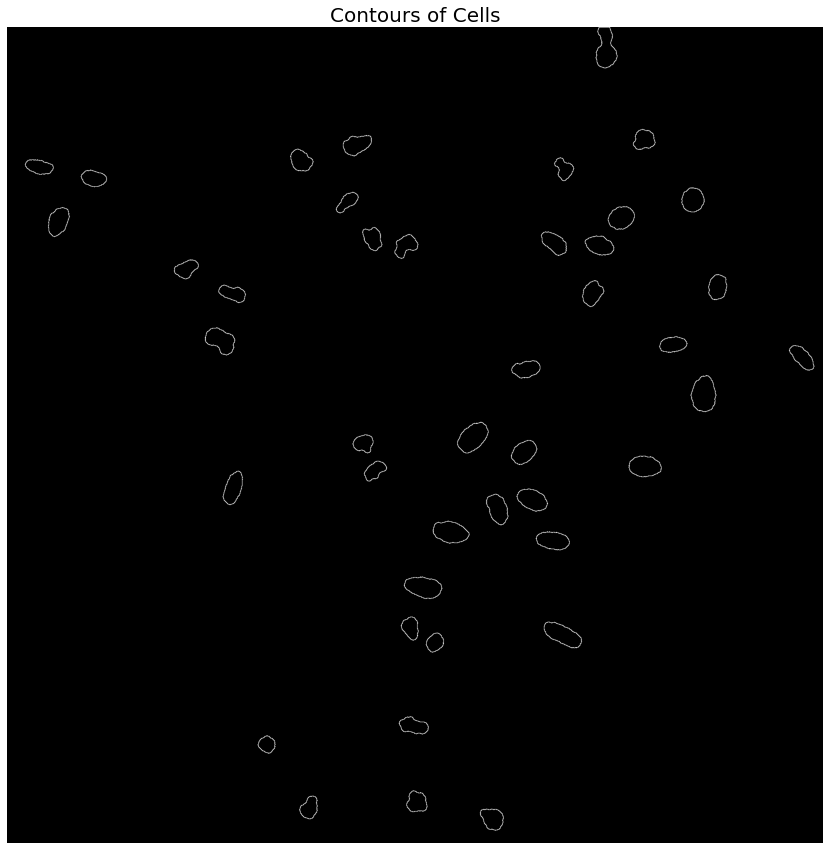

In [13]:
cell_contour = np.zeros(img.shape)
for i in range(num_cells):
    cell_contour += contours[i]

plt.figure(figsize=(15, 15))

plt.imshow(cell_contour,'gray')
plt.axis('off')
plt.title('Contours of Cells', fontsize=20)
plt.show()

In [20]:
binary_dir = "/home/cullen/nfs/gorbsky_data/binary_data/thresh_500/"
bin_files = [f for f in os.listdir(binary_dir) if f.endswith(".tif")]

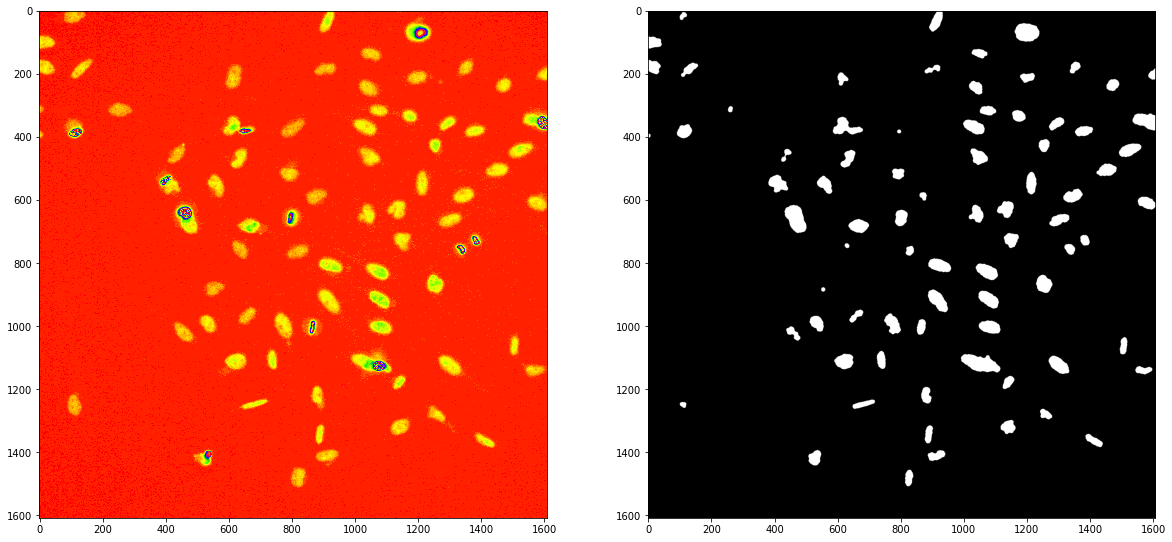

In [24]:
plt.figure(figsize=(20, 15))

i = 288
plt.subplot(121)
plt.imshow(imread(load_dir+files[0])[i],cmap='prism')
# plt.colorbar()

plt.subplot(122)
plt.imshow(imread(binary_dir+bin_files[0])[i],cmap='gray')

plt.show()


Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
25.17443037033081
0.9498577117919922


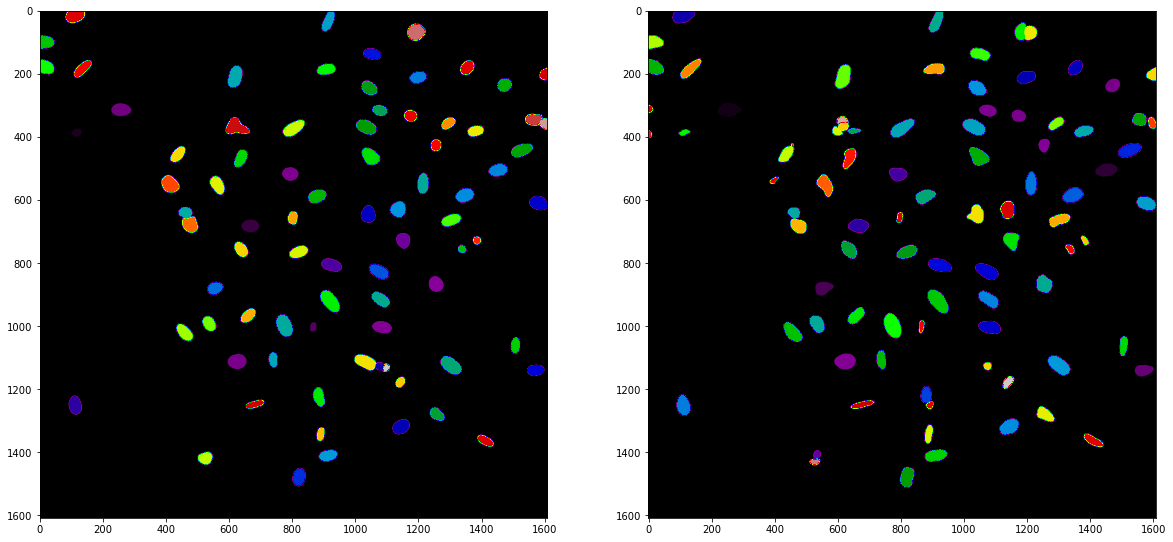

In [10]:
from csbdeep.utils import normalize
from skimage.morphology import disk
from skimage.filters import median
import cv2

from stardist.models import StarDist2D
import time


model = StarDist2D.from_pretrained('2D_versatile_fluo')

plt.figure(figsize=(20, 15))

selem = disk(18)

i = 288
img_ski = imread(load_dir+files[0])[i]

plt.subplot(121)
start = time.time()
labels1, _ = model.predict_instances(normalize(median(img_ski,selem)))
end = time.time()
print(end - start)
plt.imshow(labels1, cmap='nipy_spectral')

plt.subplot(122)
start = time.time()
labels2, _ = model.predict_instances(normalize(cv2.medianBlur(img_ski,5)))
end = time.time()
print(end - start)
plt.imshow(labels2, cmap='nipy_spectral')

plt.show()

In [4]:
# load_dir = "/gorbsky_data/input_data/"
# files = [f for f in os.listdir(load_dir) if f.endswith(".tif")]

In [5]:
# from tqdm.notebook import tqdm
# import numpy as np
# from skimage.io import imread, imsave

# # reduce noise with morphological filter
# from skimage.morphology import opening, closing, disk

# selem = disk(6)
# count = 0
# for f in files:
#     count +=1
#     imgs = imread(load_dir+f)
#     new_imgs = np.empty_like(imgs)
#     for i in tqdm(range(imgs.shape[0])):
#         img = imgs[i]
#         img_dn = closing(opening(img, selem), selem)
#         new_imgs[i] = img_dn
#     imsave(load_dir+"clean/"+f, new_imgs)
#     print("{} out of {} files cleaned and saved".format(count, len(files)))